# Applying Long Short Term Memory to predict the stock price
---
This notebook is a predictive analysis of 'Closing' stock price of Apple Inc using another type of Recurrent Neural Network that is called Long Short Term Memory(LSTMs). The purpose of the assignment is to understanding the advantages LSTMs offers and the improvement from original Recurrent Neural Network(RNN). 


The notebook need to install two libraries that are Tensorflow 2.2.0 and Yfinance. 

*   In Tensorflow, we use Keras library to build and train a model.
*   Yfinance is used to get a stock dataset of a company from Yahoo's API.

<br> The commands below will install two libraries if they did not exist on a machine. If the machine doesn't have pip package manager, please refer to [this link ](https://pip.pypa.io/en/stable/installing/) to install pip before executing the commands.

In [0]:
!pip install tensorflow==2.2.0
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=d847268d802b3f3a1f975722012600bf251b4e1525a96a98f3fd4fea91b10e1c
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


Initialize a dataframe of Apple stock history since it published. This analysis only use a univariate series. We choose a series of Closing price.

In [0]:
apple = yf.Ticker("AAPL")
apple = apple.history(period="max")
apple = apple[['Close']]
apple.shape

(9935, 1)

We normalize the dataset which all data converts into the numbers in range(0,1) so we can improve the network converges when starting training a model.

In [0]:
normalize_scaler = MinMaxScaler()
normalized_dataset = normalize_scaler.fit_transform(apple)

Create a function to slice the dataset into chunks. We will predict the price of next value based on previous values of a chunk.
---
Since the dataset is a time series, there might occur sequence bias which make the model less accuracy in prediction. Additionally, it has a chance of overfitting because the model has well training on window dataset in the training series. We decide to shuffle the dataset to increase convergence in training. To improve performance and execution time while training a model, we split the into small batches and use prefetch function in Tensorflow.data API. It means as the model is executing the training on one step, the input pipeline is loading the data for next.


In [0]:
def window_dataset(series, window_size, batch_size, shuffle_size):
    """ Function will slice the series dataset into 
        small lists of item have a size of window_size argument.                        
        
        Return the dataset with lists of tuples of 2 which has
        first element is a list of item except the last,
        second element is last element.
    """
    # series = tf.expand_dims(series, axis=-1) #reshape the dataset to fit LSTM model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda ds : ds.batch(window_size + 1))
    ds = ds.shuffle(shuffle_size)
    ds = ds.map(lambda ds: (ds[:-1], ds[-1:]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

We learned if we can split the dataset into small batches while training a model can affect the learning speed as well as the learning accuracy regarding to this Youtube [video](https://www.youtube.com/watch?v=4qJaSmvhxi8). We will use this as a hyperparameter to train our neural network model. 
<br>For this assignment we will predict the each next day by using data from previous 60 days of its.

In [0]:
window_size = 60
batch_size = 128
shuffle_size = 500

Setting the size for training set and test set.

In [0]:
split_ratio = 0.8
train_size = int(split_ratio * len(normalized_dataset))
valid_size = int(len(normalized_dataset) - train_size)

In [0]:
x_train = normalized_dataset[:train_size]
x_valid = normalized_dataset[train_size:]

Create a function to predict the next value of each averaging window period after model has been trained.

In [0]:
def model_forecast(model, series, window_size):
    """ Function will split the dataset into small chunks have size of window_size.
        The model after training will predict the next value of each chunk.

        Return the dataset which includes the next predicted value of each window period
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Implementation of Long Short Term Memory(LSTMs) 

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Conv1D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber

Create LSTMs with two layers include 64 neuron units each and one Dense output. 
We keep the sigmoid function for forget, input, and output gate as default. Regarding to this [article](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b), we choose 20% drop out to prevent overfitting by ignoring selected neurons randomly and reduce the sensitivity to specific weights of neurons. 

<br>To increase the reproducibilty, we set both the global see and the operation seed. Finding a good learning rate is challenge. Thus, we use dynamic learning rate in a range between 1e-7 and 1e+2 to by applying callback to find an optimal learning rate. 

<br>In addition, to improve excution and optimize the model we apply Stochastic Gradient Descent(SGD). SGD algorithm calculate the errors and updates the model for each samples; therefore it is able to increase the model update frequency and speed up in model learning. 

<br>For evaluating performance of a model we need metrics which is errors between forecast values and actual values.

            forecast - actual = error
            
<br>Because the value of the time series is stock price, the error can be negative value. Mean Absolute Errors(MAE) and Mean Squared Errors(MSE) are good options for measuring the errors. However, MSE has the issue with outlier values which gives more weight to outlierr and thus the model get a high error. MAE is more robust to outliers but its gradient is the same throughout which means the gradient will be the same from large values to small values. From this [article](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0), we learned that Huber function is a balance of MAE and MSE. It's not sensitive to outlier values as MSE loss. It also conduct absolute operation when its parameter 𝛿, approaches to 0. 

In [0]:
#Number of neuron or units of a LSTM layer
lstm_units = 64

# This variable is Verbosity mode when executes model training (0 = silent, 1 = progress bar)
verbose_mode = 0

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = Sequential([
          LSTM(units=lstm_units, return_sequences=True, 
               dropout=0.2, recurrent_activation='sigmoid'),
          Dense(1)                                                                     
])

lr_callback = LearningRateScheduler(
    lambda epoch : 1e-7 * 10**(epoch/20)
)

optimizer_SGD = optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(optimizer=optimizer_SGD, 
              loss=Huber(), 
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_callback], verbose=verbose_mode)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

62/62 [==============================] - 1s 18ms/step - loss: 8.5549e-04 - mae: 0.0183 - lr: 1.0000e-07
Epoch 2/100
62/62 [==============================] - 1s 19ms/step - loss: 8.5579e-04 - mae: 0.0183 - lr: 1.1220e-07
Epoch 3/100
62/62 [==============================] - 1s 19ms/step - loss: 8.5563e-04 - mae: 0.0183 - lr: 1.2589e-07
Epoch 4/100
62/62 [==============================] - 1s 19ms/step - loss: 8.5569e-04 - mae: 0.0183 - lr: 1.4125e-07
Epoch 5/100
62/62 [=========================

### Prediction
Calling model_forecast function to predict next value of each previous 60 day period. The return will be a series of the price of next day that model predicted. The size of series is the same of actual validation dataset(x_valid) since we need to use to compare the trend two datasets.

In [0]:
lstm_forecast = model_forecast(model, normalized_dataset, window_size)
lstm_predicted= lstm_forecast[train_size - window_size:-1, -1]

((1987, 1), (1987, 1))

In [0]:
def plot_actual_predict(actual, predict):
    """
        Plot a graph represents the relation between actual values
        and prediction values
    """

    plt.figure(figsize=(10, 8))
    a = plt.plot(actual, label='Actual')
    p = plt.plot(predict, label='Prediction')
    plt.legend()
    plt.show()

### Result

Plot the graph to compare between actual values and the predicted values after model has been trained

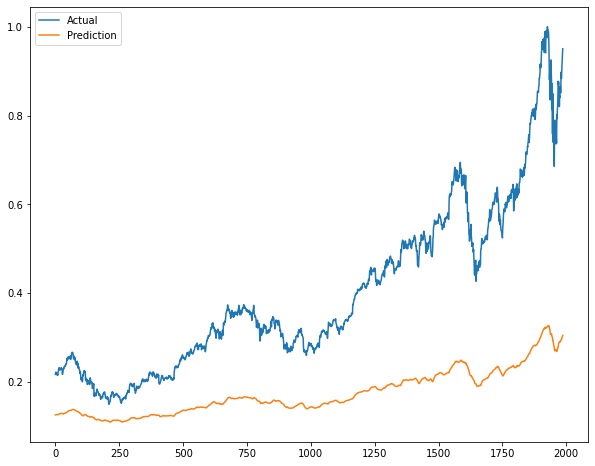

In [0]:
plot_actual_predict(x_valid, lstm_predicted)

As we can see the prediction picked up the trend of the actual value. However, the prediction is really low compare to actual values.

This function will reverse validation dataset and prediction dataset to regular value of stock price, then calculate Mean Abosolute Error and Mean Squared Error of two datasets

In [0]:
def cal_unscaled_error(validation, prediction):
  """
    Calculate the Absolute Mean Error loss between the validation dataset
    and the prediction dataset
  """
  unscaled_lstm_valid = normalize_scaler.inverse_transform(prediction)
  unscaled_valid = normalize_scaler.inverse_transform(validation)
  mae = tf.keras.metrics.mean_absolute_error(unscaled_lstm_valid[:,0], unscaled_valid[:,0]).numpy()
  mse = tf.keras.metrics.mean_squared_error(unscaled_lstm_valid[:,0], unscaled_valid[:,0]).numpy()
  print("Mean Squared Error: ",mse)
  print("Mean Absolute Error: ",mae)

In [0]:
cal_unscaled_error(x_valid, lstm_predicted)

Mean Squared Error:  7465.351401487253
Mean Absolute Error:  73.33160112040213


Regarding to the graph and two metric values above, the distance between a actual value point and a prediction value point are large, the prediction of model is not really accurate. We will keep these values as a base to tune in our model.

## Tuning Model - first time

After doing some research we found out that Convolution Neural Network can help to extract the important featuress before passing on to LSTM layers for processing. Because the dataset is a univariate time series, we will convolution 1d neural network(Conv1D). 

"Causual" argument will add leading 0s into the layers' input so we can predict the values of early time steps. It also keeps the size of outputs same as the inputs to avoid losing data from filtering. Also using "causual" helps the model can be trained on incomplete units. Since stock price is never negative value, we decide using Relu function for output activation layers. 

<br>We also add another Dense layer for each LSTM's units and last Dense layer as a fully connected layer for output.

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = Sequential([
          Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
          LSTM(lstm_units, return_sequences=True, 
                       dropout=0.2, recurrent_activation='sigmoid'),  
          Dense(lstm_units),                                                
          Dense(1)                                                                     
])                                                                   

lr_callback = LearningRateScheduler(
    lambda epoch : 1e-7 * 10**(epoch/20)
)

optimizer_SGD = optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(optimizer=optimizer_SGD, 
              loss=Huber(),
              metrics=['mse'])

history = model.fit(train_set, epochs=120, callbacks=[lr_callback], verbose=verbose_mode)


Epoch 1/120
62/62 [==============================] - 1s 18ms/step - loss: 5.9673e-04 - mse: 0.0012 - lr: 1.0000e-07
Epoch 2/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9691e-04 - mse: 0.0012 - lr: 1.1220e-07
Epoch 3/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9715e-04 - mse: 0.0012 - lr: 1.2589e-07
Epoch 4/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9674e-04 - mse: 0.0012 - lr: 1.4125e-07
Epoch 5/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9681e-04 - mse: 0.0012 - lr: 1.5849e-07
Epoch 6/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9568e-04 - mse: 0.0012 - lr: 1.7783e-07
Epoch 7/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9614e-04 - mse: 0.0012 - lr: 1.9953e-07
Epoch 8/120
62/62 [==============================] - 1s 19ms/step - loss: 5.9655e-04 - mse: 0.0012 - lr: 2.2387e-07
Epoch 9/120
62/62 [==============================] - 1s 19ms/step - loss

Plot the graph represents the changes of learning rate and loss in 120 timesteps.

<function matplotlib.pyplot.show>

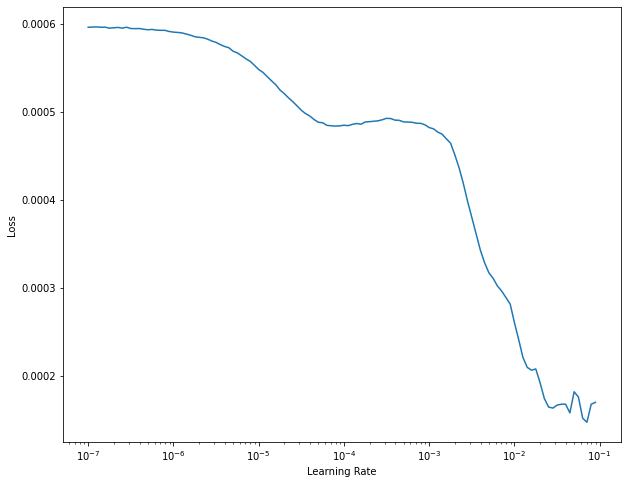

In [0]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show

As we can see the curve looks really good between $10^{-5}$ and  $10^{-4}$ which mean the slope go close to minimum value. We could find an optimal learning rate start at  $10^{-5}$ instead  $10^{-7}$.

### Result

Calculate the prediction and plot the graph of actual and prediction after training.

In [0]:
lstm_forecast = model_forecast(model, normalized_dataset, window_size)
lstm_predicted = lstm_forecast[train_size - window_size:-1, -1]

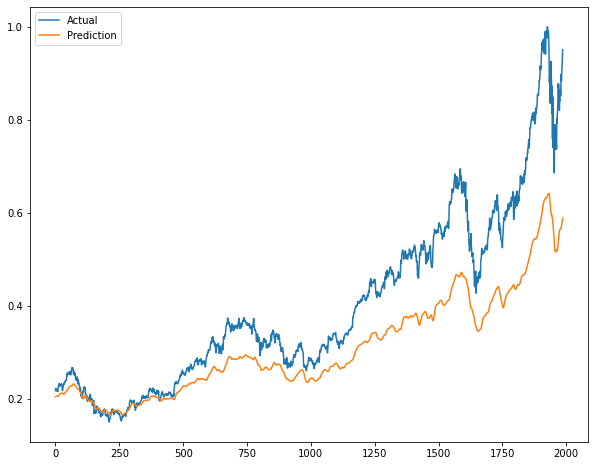

In [0]:
plot_actual_predict(x_valid, lstm_predicted)

In [0]:
cal_unscaled_error(x_valid, lstm_predicted)

Mean Squared Error:  1575.8841051201289
Mean Absolute Error:  29.59005735231274


From the result of error evaluation, we can see the prediction of model has improved. MSE and MAE loss has decreased significantly.

| Error Metric| Previous    | Current       |
| :---        |    :----:   |          ---: |
| **MSE**         | 7465.351    | 1575.884      |
| MAE         | 73.331      | 29.59         |

_____


## Tuning Model - Second Time

We adjust the callback function to $10^{-5}$ based on the graph of the learning rate and the loss to narrow the optimal range of learning rate. 

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True, 
                       dropout=0.2, recurrent_activation='sigmoid', activation='tanh'),  
  tf.keras.layers.Dense(64),                                                
  tf.keras.layers.Dense(1)                                                                     
])

lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-5 * 10**(epoch/20)
)

optimizer_SGD = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(optimizer=optimizer_SGD, 
              loss=tf.keras.losses.Huber(),
              metrics=['mse'])

history = model.fit(train_set, epochs=100, callbacks=[lr_callback], verbose=verbose_mode)


Epoch 1/100
62/62 [==============================] - 1s 20ms/step - loss: 5.9520e-04 - mse: 0.0012 - lr: 1.0000e-05
Epoch 2/100
62/62 [==============================] - 1s 20ms/step - loss: 5.8834e-04 - mse: 0.0012 - lr: 1.1220e-05
Epoch 3/100
62/62 [==============================] - 1s 21ms/step - loss: 5.8114e-04 - mse: 0.0012 - lr: 1.2589e-05
Epoch 4/100
62/62 [==============================] - 1s 21ms/step - loss: 5.7301e-04 - mse: 0.0011 - lr: 1.4125e-05
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 5.6517e-04 - mse: 0.0011 - lr: 1.5849e-05
Epoch 6/100
62/62 [==============================] - 1s 21ms/step - loss: 5.5597e-04 - mse: 0.0011 - lr: 1.7783e-05
Epoch 7/100
62/62 [==============================] - 1s 21ms/step - loss: 5.4830e-04 - mse: 0.0011 - lr: 1.9953e-05
Epoch 8/100
62/62 [==============================] - 1s 20ms/step - loss: 5.4065e-04 - mse: 0.0011 - lr: 2.2387e-05
Epoch 9/100
62/62 [==============================] - 1s 22ms/step - loss

### Result

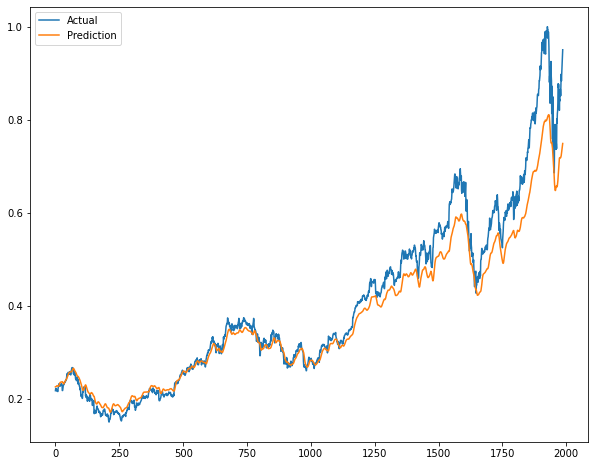

In [0]:
lstm_forecast = model_forecast(model, normalized_dataset, window_size)
lstm_predicted = lstm_forecast[train_size - window_size:-1, -1]
plot_actual_predict(x_valid, lstm_predicted)

Calculate the MSE and MAE of current model

In [0]:
cal_unscaled_error(x_valid, lstm_predicted)

Mean Squared Error:  275.4902484693631
Mean Absolute Error:  10.784361757797756


As the table result showed below, the model has great improvement in training. The prediction chart picked up the trend of the actual even up and down. There is a bit lagging in correlation between actual and predict values. We might improve it by tuning the hyper-parameters of optimizer.

| Error Metric| Previous    | Current       |
| :---        |    :----:   |          ---: |
| **MSE**     |  1575.884   | 275.49024     |
| MAE         | 29.59       | 10.7843       |

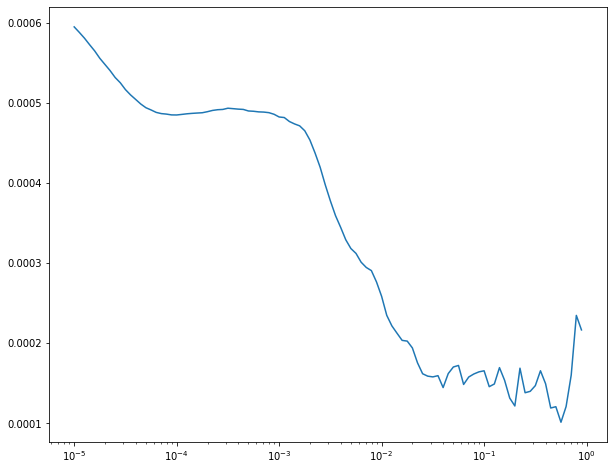

In [0]:
plt.figure(figsize=(10,8))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.show()

As the image indicated, the gradient of graph is getting to minimal values as the learning rate goes from $10^{-5}$ to $5.10^{-5}$. We decide to pick up a new learning rate which is $3.10^{-5}$ for next training.
___

## Tuning Model - Third Time

This training we will use a common optimization algorithm that is Adaptive Moment Estimation(Adam). Adam takes advantages of momentum in Schocastic Gradient Descent(SGD) by using moving average of the gradient instead of gradient SGD itself. Thus, it can accelerate gradients vectors in the right directions. Since Adam is a adaptive learning method, it's able to computes individual learning rates for different parameters.  

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, batch_size, shuffle_size)

print(train_set),
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True, 
                       dropout=0.2, recurrent_activation='sigmoid'),  
  tf.keras.layers.Dense(64),                                                
  tf.keras.layers.Dense(1)                                                                     
])

optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer_Adam,
              loss='mse')

history = model.fit(train_set, epochs=100, verbose=verbose_mode)



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(7948, 1)
Epoch 1/100
62/62 [==============================] - 1s 19ms/step - loss: 6.4314e-04
Epoch 2/100
62/62 [==============================] - 1s 20ms/step - loss: 7.1467e-04
Epoch 3/100
62/62 [==============================] - 1s 21ms/step - loss: 3.4898e-04
Epoch 4/100
62/62 [==============================] - 1s 22ms/step - loss: 2.0051e-04
Epoch 5/100
62/62 [==============================] - 1s 20ms/step - loss: 1.4956e-04
Epoch 6/100
62/62 [==============================] - 1s 20ms/step - loss: 1.3926e-04
Epoch 7/100
62/62 [==============================] - 1s 20ms/step - loss: 1.3466e-04
Epoch 8/100
62/62 [==============================] - 1s 21ms/step - loss: 1.3127e-04
Epoch 9/100
62/62 [==============================] - 1s 21ms/step - loss: 1.2646e-04
Epoch 10/100
62/62 [==============================] - 1s 21ms/step - loss: 1.2306e-04
Epoch 11/100
62/62 [=========================

Predict the next values and plot the graph between actual values in validation dataset and  prediction values from the dataset model just predicted.

### Result

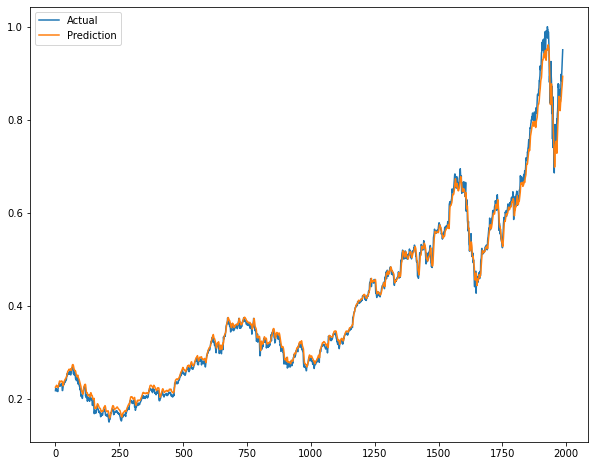

In [0]:
lstm_forecast = model_forecast(model, normalized_dataset, window_size)
lstm_predicted = lstm_forecast[train_size - window_size:-1, -1]
plot_actual_predict(x_valid, lstm_predicted)

Enlarge first half and second half of the chart above 

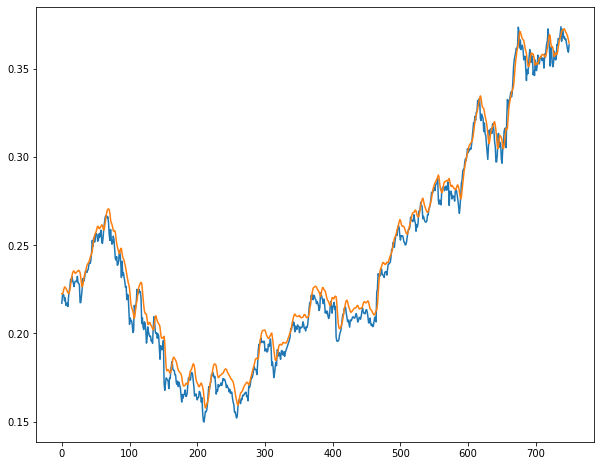

In [0]:
  plt.figure(figsize=(10, 8))
  plt.plot(x_valid[: 750])
  plt.plot(lstm_predicted[: 750])
  plt.show()

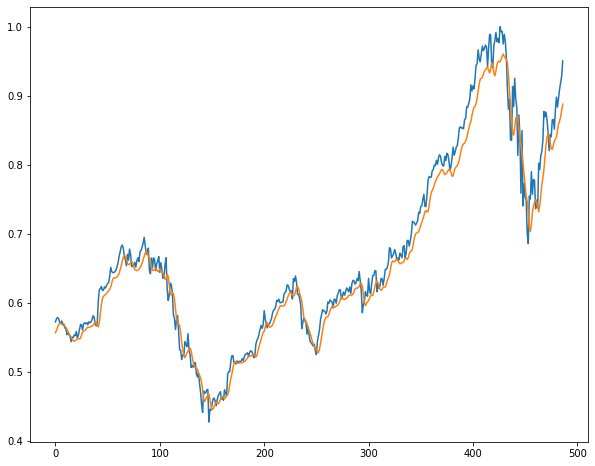

In [0]:
  plt.figure(figsize=(10, 8))
  plt.plot(x_valid[1500:])
  plt.plot(lstm_predicted[1500:])
  plt.show()

Compute the MSE and MAE of validation and prediction values after rescale back to regular values.

In [0]:
cal_unscaled_error(x_valid, lstm_predicted)

Mean Squared Error:  18.60082693326764
Mean Absolute Error:  3.007348476077782


As we can see from the above result of error evaluation, the model improved significantly. Current MAE reduced more than a half of previous MAE.

| Error Metric| Previous    | Current       |
| :---        |    :----:   |          ---: |
| **MSE**     | 275.49024   | 18.6008       |
| **MAE**     | 10.7843     | 3.00734       |

Adam optimize really enhanced the training model. Although there is little lag behind the actual validation value graph, it indicate a improvement in choosing a good hyperparameter optimizer and a good learning rate.

# Conclusion

* After working on building a stock prediction model using Recurrent 
Neural Network(RNN) and Long Short Term Memory(LSTM), we can see LSTM works much better than RNN in prediction. In fact, LSTMs remembers information from both previous inputs and previous outputs. It can connect the information between current units and previous units back and forth. While there is a gap in RNN model, it can not memorize the context from further back. Thus, LSTMs enhances the capable of handling long-tem depedencies. 

* In addition, we believe adding hyper-parameter and layer properly will improve the training significantly. For instance, we added a Conv-1D layer into the model, the result was very good. The Conv1D layer improved the filtering of the data before passing to LSTMs layer to process information.

* Overall, we have gained a lot about Machine Learning in concept as well as techniques from these assignments. We learned how to create a Machine Learning model for prediction next value of time series dataset. We understand Machine Learning concepts such as hidden layer, activation function, or learning rate through adding hyper-parameter to tune the models. We learned how to find a good learning rate during training time. Additionally, tuning a model is the part we spent a lot of time on. We believe a model will be better if it is set correct hyper-parameters and proper training timesteps. 

* Although, our model was not really accurate, it improved significantly after many attempts. Stock mark relies on many circumstances such as news or companies' situation, it is not possible to predict the correct behavior using only its historical price.



# Reference

[Adam Optimizer](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) 

[Huber Loss & Learning Rate](https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de)

Choosing Activation & Non-Activation Function
https://www.youtube.com/watch?v=Xvg00QnyaIY
https://engmrk.com/activation-function-for-dnn/
https://www.youtube.com/watch?v=NkOv_k7r6no

[Mean Absolute Error & Mean Square Error](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
)

[Long Short Term Memory](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Recurrent Neural Network](https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html
)

[Learning Rate](https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de)